# 自定义数据在pyborker策略中的使用

https://www.pybroker.com/zh-cn/latest/notebooks/7.%20Creating%20a%20Custom%20Data%20Source.html

In [ ]:
import pybroker
from pybroker.ext.data import AKShare
from pybroker import ExecContext, StrategyConfig, Strategy
import matplotlib.pyplot as plt
from datetime import datetime
import riskfolio as rp
import akshare as ak
import pandas as pd
import numpy as np
import sqlite3
import datetime

import talib
from pybroker.vect import cross

#正常显示画图时出现的中文和负号
from pylab import mpl

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

akshare = AKShare()

pybroker.enable_data_source_cache('akshare')

In [3]:
ak.__version__

'1.16.60'

## pybroker的数据形式

In [4]:
df = akshare.query(
    symbols=['000001.SZ', '600000.SH'],
    start_date='3/2/2021',
    end_date='3/1/2023',
    adjust="hfq",
    timeframe="1d",
)
df

Loaded cached bar data.



,date,symbol,open,high,low,close,volume
0,2021-03-02,000001.SZ,3653.44,3739.58,3594.93,3658.31,1473425
1,2021-03-03,000001.SZ,3646.94,3890.73,3627.43,3879.35,1919635
2,2021-03-04,000001.SZ,3840.34,3957.36,3820.84,3864.72,1213579
3,2021-03-05,000001.SZ,3828.97,3874.48,3692.44,3770.46,880171
4,2021-03-08,000001.SZ,3786.71,3827.34,3630.68,3650.19,993774
...,...,...,...,...,...,...,...
967,2023-02-23,600000.SH,77.41,77.61,77.28,77.28,114365
968,2023-02-24,600000.SH,77.22,77.48,76.95,76.95,166811
969,2023-02-27,600000.SH,76.82,77.08,76.82,76.82,158006
970,2023-02-28,600000.SH,76.95,77.08,76.69,76.95,174481


In [5]:
def trying_strategy(ctx: ExecContext):
    high = ctx.high[-11:-1].max()
    low = ctx.low[-11:-1].min()
    #print(high, low)

    if not ctx.long_pos() and ctx.close[-1] > high:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
        #print(ctx.dt, "buy")
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()
        #print(ctx.dt, "sell")

In [6]:
strategy = Strategy(akshare, start_date='2020-01-01', end_date='2023-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'])
result = strategy.backtest(warmup=15)

Backtesting: 2020-01-01 00:00:00 to 2023-01-01 00:00:00

Loaded cached bar data.

Test split: 2020-01-02 00:00:00 to 2022-12-30 00:00:00


  0% (0 of 728) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 22% (161 of 728) |####                  | Elapsed Time: 0:00:00 ETA:   0:00:00
 37% (271 of 728) |########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 61% (451 of 728) |#############         | Elapsed Time: 0:00:00 ETA:   0:00:00
 89% (651 of 728) |###################   | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (728 of 728) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:04


In [7]:
#result.trades

## 获取本地数据转化为pybroker数据形式

In [8]:
conn=sqlite3.connect(r'I:\量化金融\stock_2018.db')
stock_daily0=pd.read_sql("select * from stock_daily where 交易日期>'20200101' and 交易日期<'20210101' ",con=conn)
stock_daily0.head()

,index,交易日期,股票代码,股票简称,开盘价,最高价,最低价,收盘价,成交量(手),成交额(千元),...,市盈率(动态),市净率,市销率,市销率(TTM),股息率(%),股息率(TTM)(%),总股本(万股),流通股本(万股),总市值(万元),流通市值(万元)
0,6807,20200102,000002.SZ,万科A,4867.9136,4986.6432,4824.8741,4832.2947,1012130.40,3342373.870,...,NaN,2.2000,1.2362,1.0649,3.2098,3.2098,1.130214e+06,971517.0043,3.679978e+07,3.163259e+07
1,6808,20200103,000002.SZ,万科A,4854.5565,4869.3977,4716.5334,4756.6046,805536.29,2584309.903,...,14.89,2.1655,1.2169,1.0482,3.2608,3.2608,1.130214e+06,971517.0043,3.622337e+07,3.113712e+07
2,6809,20200106,000002.SZ,万科A,4712.0810,4713.5651,4637.8750,4676.4621,876840.58,2761448.649,...,14.64,2.1290,1.1964,1.0306,3.3167,3.3167,1.130214e+06,971517.0043,3.561305e+07,3.061250e+07
3,6810,20200107,000002.SZ,万科A,4691.3033,4738.7952,4652.7162,4713.5651,577933.43,1827510.871,...,14.76,2.1459,1.2058,1.0387,3.2906,3.2906,1.130214e+06,971517.0043,3.589561e+07,3.085538e+07
4,6811,20200108,000002.SZ,万科A,4645.2956,4715.0492,4608.1926,4701.6922,529996.84,1667143.803,...,14.72,2.1405,1.2028,1.0361,3.2989,3.2989,1.130214e+06,971517.0043,3.580519e+07,3.077766e+07


In [9]:
stock_daily0.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [10]:
stock_daily0["交易日期"]=pd.to_datetime(stock_daily0["交易日期"].astype(str))

In [11]:
pyb_data=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)"]]
pyb_data.columns=["date","symbol","open","high","low","close","volume"]

In [12]:
pyb_data.head()

,date,symbol,open,high,low,close,volume
0,2020-01-02,000002.SZ,4867.9136,4986.6432,4824.8741,4832.2947,1012130.40
1,2020-01-03,000002.SZ,4854.5565,4869.3977,4716.5334,4756.6046,805536.29
2,2020-01-06,000002.SZ,4712.0810,4713.5651,4637.8750,4676.4621,876840.58
3,2020-01-07,000002.SZ,4691.3033,4738.7952,4652.7162,4713.5651,577933.43
4,2020-01-08,000002.SZ,4645.2956,4715.0492,4608.1926,4701.6922,529996.84


In [13]:
strategy = Strategy(pyb_data, start_date='2020-04-01', end_date='2021-01-01')
strategy.add_execution(trying_strategy, ['000001.SZ','002594.SZ'])
result = strategy.backtest(warmup=15)

Backtesting: 2020-04-01 00:00:00 to 2021-01-01 00:00:00

Test split: 2020-04-01 00:00:00 to 2020-12-31 00:00:00


  0% (0 of 185) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 65% (121 of 185) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (185 of 185) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:00


In [14]:
result.metrics_df.head()

,name,value
0,trade_count,9.00
1,initial_market_value,100000.00
2,end_market_value,165394.46
3,total_pnl,61363.79
4,unrealized_pnl,4030.67


<Axes: xlabel='date'>

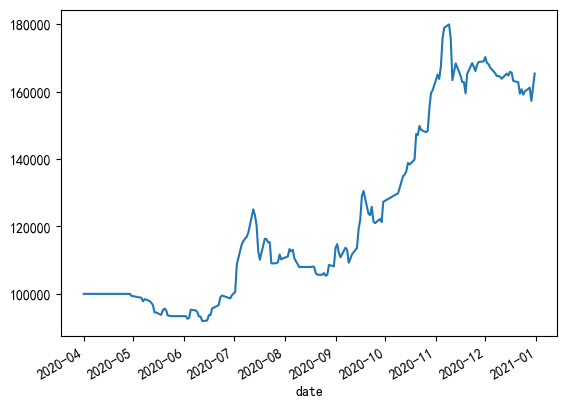

In [15]:
result.portfolio.equity.plot()

## 引入指标

In [16]:
pyb_data_pe=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","市盈率(静态)"]]
pyb_data_pe.columns=["date","symbol","open","high","low","close","volume","pe"]

In [17]:
pybroker.register_columns('pe')

In [18]:
pyb_data_pe.pe.median()

44.6277

In [19]:
pyb_data_pe.symbol.unique()[100:120]

array(['000504.SZ', '000505.SZ', '000506.SZ', '000507.SZ', '000509.SZ',
       '000510.SZ', '000513.SZ', '000514.SZ', '000516.SZ', '000517.SZ',
       '000518.SZ', '000519.SZ', '000520.SZ', '000521.SZ', '000523.SZ',
       '000524.SZ', '000525.SZ', '000526.SZ', '000528.SZ', '000529.SZ'],
      dtype=object)

In [20]:
def trying_strategy_pe(ctx: ExecContext):
    high = ctx.high[-11:-1].max()
    low = ctx.low[-11:-1].min()
    #print(ctx.pe[-1])

    if not ctx.long_pos() and ctx.close[-1] > high and ctx.pe[-1] < 20:
        ctx.buy_shares = ctx.calc_target_shares(0.5)
    
    if ctx.long_pos() and ctx.close[-1] < low:
        ctx.sell_all_shares()

In [21]:
pybroker.register_columns('pe')
strategy = Strategy(pyb_data_pe, start_date='2020-04-01', end_date='2021-01-01')
strategy.add_execution(trying_strategy_pe, pyb_data_pe.symbol.unique()[100:120])
result = strategy.backtest(warmup=15)

Backtesting: 2020-04-01 00:00:00 to 2021-01-01 00:00:00

Test split: 2020-04-01 00:00:00 to 2020-12-31 00:00:00


  0% (0 of 185) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 16% (31 of 185) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 38% (71 of 185) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (121 of 185) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (185 of 185) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:00


In [22]:
result.metrics_df.head()

,name,value
0,trade_count,1.100000e+01
1,initial_market_value,1.000000e+05
2,end_market_value,1.182277e+05
3,total_pnl,1.822773e+04
4,unrealized_pnl,-3.637979e-12


<Axes: xlabel='date'>

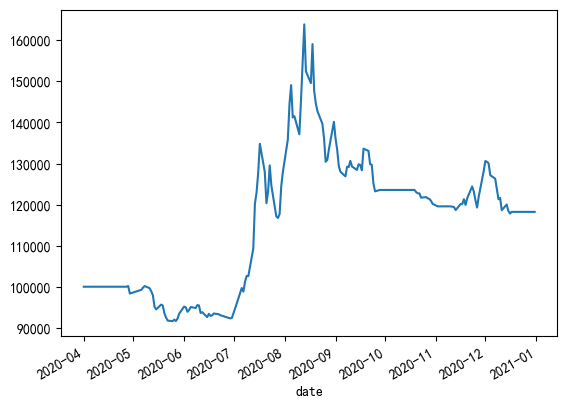

In [23]:
result.portfolio.equity.plot()

## 自定义数据源类

### 

In [ ]:
from pybroker.data import DataSource

class DFDataSource(DataSource):
    def __init__(self, data):
        super().__init__()
        pybroker.register_columns('pe')
        self.data = data

    def _fetch_data(self, symbols, start_date, end_date, _timeframe, _adjust):
        df = self.data
        df = df[df['symbol'].isin(symbols)]
        return df[(df['date'] >= start_date) & (df['date'] <= end_date)]

In [25]:
pyb_data_pe=stock_daily0[["交易日期","股票代码","开盘价","最高价","最低价","收盘价","成交量(手)","市盈率(静态)"]]
pyb_data_pe.columns=["date","symbol","open","high","low","close","volume","pe"]

In [29]:
data_source = DFDataSource(pyb_data_pe)
strategy = Strategy(data_source,'2020-04-01','2021-01-01')
strategy.add_execution(trying_strategy_pe, pyb_data_pe.symbol.unique()[100:220])
result = strategy.backtest(warmup=15)

Backtesting: 2020-04-01 00:00:00 to 2021-01-01 00:00:00

Loading bar data...
Loaded bar data: 0:00:01 

Test split: 2020-04-01 00:00:00 to 2020-12-31 00:00:00


  0% (0 of 185) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 11% (21 of 185) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 16% (31 of 185) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:01
 22% (41 of 185) |#####                  | Elapsed Time: 0:00:00 ETA:   0:00:01
 32% (61 of 185) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (81 of 185) |##########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 54% (101 of 185) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (121 of 185) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 76% (141 of 185) |################      | Elapsed Time: 0:00:00 ETA:   0:00:00
 87% (161 of 185) |###################   | Elapsed Time: 0:00:00 ETA:   0:00:00
 97% (181 of 185) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (185 of 185) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Finished backtest: 0:00:02


In [30]:
result.metrics_df.head()

,name,value
0,trade_count,31.00
1,initial_market_value,100000.00
2,end_market_value,95740.66
3,total_pnl,-9110.55
4,unrealized_pnl,4851.21


In [28]:
data_source.query(['000001.SZ','002594.SZ'], '2020-01-01', '2020-01-31').head()

Loaded cached bar data.



,date,symbol,open,high,low,close,volume,pe
543680,2020-01-02,000001.SZ,1817.6638,1850.4146,1806.7470,1841.6810,1530231.87,13.1911
543681,2020-01-03,000001.SZ,1849.3229,1889.7154,1847.1395,1875.5234,1116194.81,13.4335
543682,2020-01-06,000001.SZ,1856.9647,1892.9905,1846.0478,1863.5148,862083.50,13.3475
543683,2020-01-07,000001.SZ,1870.0650,1886.4403,1850.4146,1872.2484,728607.56,13.4101
543684,2020-01-08,000001.SZ,1855.8730,1861.3314,1815.4805,1818.7555,847824.12,13.0269
